In [2]:
import pandas as pd
import numpy as np
import matplotlib.pyplot as plt
import pickle
%matplotlib inline

from sklearn.model_selection import train_test_split, KFold, cross_val_score, cross_val_predict, cross_validate
from sklearn.linear_model import LinearRegression, Lasso, LassoCV, Ridge, RidgeCV
from sklearn.svm import SVR
from sklearn.decomposition import PCA
from sklearn.cross_decomposition import PLSRegression
from sklearn.metrics import mean_squared_error, r2_score
from sklearn.model_selection import GridSearchCV

from helper_functions import (full_training_set_scores,
                              print_scores,
                              kfold_validate_score,
                              component_reduction,
                              add_baselines,
                              pls_comp_list)

## Import Data and Split into Training/Test Sets

In [3]:
# Import processed data from EDA notebook
bgg = pd.read_csv('./data/bgg_processed.csv', index_col='game_id')

In [4]:
# Split off target column: `avg_rating`
y = bgg['avg_rating']
X = bgg.drop('avg_rating', axis=1).copy()

In [5]:
# set random state value for all that need it
rs = 37

In [6]:
# Split into training and testing sets
X_train, X_test, y_train, y_test = train_test_split(
    X, y, test_size=0.2, random_state=rs
)

## Initial linear regression

First let's see how simple linear regression fares. For these first examples, the model will train and predict on the entire training set. This can lead to overfitting, but these examples should give us some indication about which models are able to fit and predict the data the best.

In [6]:
# Fit and score linear regression
linear = LinearRegression().fit(X_train, y_train)

linear_r2, linear_rmse = full_training_set_scores(X_train, y_train, linear)

In [7]:
print_scores(linear_r2, linear_rmse, "Simple Linear Regression")

Simple Linear Regression:

R-squared:     0.5613
RMSE:          0.2961


In [20]:
score_range = y.max() - y.min()
print(f'The actual range of scores is: {score_range:.5}')

The actual range of scores is: 2.8474


### Linear Regression on the full test set:

The R-squared value is above 0.5, which shows the prediction line fits fairly well to the data. The RMSE is 0.29, which is just over 10% of the total range. These are pretty good initial results. The goal going forward will be to improve these numbers.

## Lasso Regression

After basic linear regression, we will examine related models: lasso and ridge regression.

In [9]:
# Fit and score lasso regression
lasso = Lasso(random_state=rs).fit(X_train, y_train)

lasso_r2, lasso_rmse = full_training_set_scores(X_train, y_train, lasso)

In [10]:
print_scores(lasso_r2, lasso_rmse, "Simple Lasso Regression")

Simple Lasso Regression:

R-squared:     0.0
RMSE:          0.447


### Lasso Regression on the full test set:

The R-squared is zero, so this line does not fit the data at all. The RMSE is a much higher 0.44. Lasso Regression may be removed as a potential model.

## Ridge Regression

In [11]:
# Fit and score ridge regression
ridge = Ridge(random_state=rs).fit(X_train, y_train)

ridge_r2, ridge_rmse = full_training_set_scores(X_train, y_train, ridge)

In [12]:
print_scores(ridge_r2, ridge_rmse, "Simple Ridge Regression")

Simple Ridge Regression:

R-squared:     0.5599
RMSE:          0.2966


### Ridge Regression on the full test set:

The R-squared and RMSE scores are extremely close to the scores of simple linear regression. There have been no parameters set, so there may be room for improvement here.

## Support Vector Regression

Using support vector regression, we can look at higher degree predictive lines easily (the line to fit the data can be curved rather than straight). 

Let's test the data on three kernels: linear (straight line), RBF (exponential curve), and poly (polynomial curve). Care must be taken to avoid overfitting, which can be a concern if the degree of the curves gets too high. For these first models, the default degree of 3 will be used.

In [13]:
svr = SVR(kernel='linear').fit(X_train, y_train)

svr_r2, svr_rmse = full_training_set_scores(X_train, y_train, svr)

In [14]:
print_scores(svr_r2, svr_rmse, "Support Vector Regression - Linear")

Support Vector Regression - Linear:

R-squared:     0.5327
RMSE:          0.3056


In [15]:
svr = SVR(kernel='rbf').fit(X_train, y_train)

svr_r2, svr_rmse = full_training_set_scores(X_train, y_train, svr)

In [16]:
print_scores(svr_r2, svr_rmse, "Support Vector Regression - RBF")

Support Vector Regression - RBF:

R-squared:     0.8807
RMSE:          0.1544


In [17]:
svr = SVR(kernel='poly').fit(X_train, y_train)

svr_r2, svr_rmse = full_training_set_scores(X_train, y_train, svr)

In [18]:
print_scores(svr_r2, svr_rmse, "Support Vector Regression - Poly")

Support Vector Regression - Poly:

R-squared:     0.8733
RMSE:          0.1591


### Support Vector Regression on the full test set:

Using a linear kernel with Support Vector Regression returns similar results as linear and ridge regression. However, the results are much improved when using RBF or Poly kernels. RBF is a squared exponential kernel, so an exponential or polynomal line seems to be a much better fit for the data.

With all of these models being trained and tested on themselves, there is the danger of over-fitting, so cross-validation will help reduce that danger.

## Cross-Validation

There are 2000 entries in the original data, so the train/test split leaves 1600 rows in the training data. 8 splits for K-Fold cross validation should be sufficient so each slice is 200 rows. The rows were already shuffled with the train/test split, so they don't need shuffled again.

Cross-validation is important to keep the model from overfitting the data.

In [19]:
# Select model for CV
linear_cv = LinearRegression()

# Return R-squared and RMSE with custom function
linear_cv_r2, linear_cv_rmse = kfold_validate_score(X_train, y_train, model=linear_cv)

# Print Average R-Squared and Average RMSE scores returned from CV
print_scores(linear_cv_r2, linear_cv_rmse, "Linear Regression Cross-Validation")

Linear Regression Cross-Validation:

R-squared:     1.146e+22
RMSE:          2.356e+10


Cross-validation with linear regression returns some truely problematic results. An average R-squared value of 16 sextillion and an average RMSE over 20 billion show that linear regression is not suitable to predict on the dataset.

## Lasso Regression

How do other methods of regression fare? First let's look at Lasso Regression:

In [20]:
# Find mean RMSE through lasso regression over 8 fold
lasso_cv = Lasso(random_state=rs)

lasso_cv_r2, lasso_cv_rmse = kfold_validate_score(X_train, y_train, model=lasso_cv)

print_scores(lasso_cv_r2, lasso_cv_rmse, "Lasso Regression Cross-Validation")

Lasso Regression Cross-Validation:

R-squared:     0.005875
RMSE:          0.4467


Basic Lasso Regression has a reasonable average RMSE, but an average R-squared in the negative, so it also doesn't seem to fit the data well. This result along with the above result, where lasso regression predicted poorly on the full training set, rule out this model being selected for the final model.

## Ridge Regression

In [21]:
# Find mean RMSE through ridge regression over 8 fold
ridge_cv = Ridge(random_state=rs)

ridge_cv_r2, ridge_cv_rmse = kfold_validate_score(X_train, y_train, model=ridge_cv)

print_scores(ridge_cv_r2, ridge_cv_rmse, "Ridge Regression Cross-Validation")

Ridge Regression Cross-Validation:

R-squared:     -0.3829
RMSE:          0.349


Ridge regression is a sligtly better than lasso with average RMSE, but the average R-squared value is showing it isn't the best fit.

## SVR

In [22]:
# Find mean RMSE through SVR Linear regression over 8 fold
svr_linear_cv = SVR(kernel='linear')

svr_linear_cv_r2, svr_linear_cv_rmse = kfold_validate_score(X_train, y_train, model=svr_linear_cv)

print_scores(svr_linear_cv_r2, svr_linear_cv_rmse, "SVR - Linear Cross-Validation")

SVR - Linear Cross-Validation:

R-squared:     -0.3391
RMSE:          0.3609


In [23]:
# Find mean RMSE through SVR Linear regression over 8 fold
svr_poly_cv = SVR(kernel='poly')

svr_poly_cv_r2, svr_poly_cv_rmse = kfold_validate_score(X_train, y_train, model=svr_poly_cv)

print_scores(svr_poly_cv_r2, svr_poly_cv_rmse, "SVR - Poly Cross-Validation")

SVR - Poly Cross-Validation:

R-squared:     6.399
RMSE:          0.6973


In [24]:
# Find mean RMSE through SVR Linear regression over 8 fold
svr_rbf_cv = SVR(kernel='rbf')

svr_rbf_cv_r2, svr_rbf_cv_rmse = kfold_validate_score(X_train, y_train, model=svr_rbf_cv)

print_scores(svr_rbf_cv_r2, svr_rbf_cv_rmse, "SVR - RBF Cross-Validation")

SVR - RBF Cross-Validation:

R-squared:     -0.4882
RMSE:          0.3179


As suspected from the above results, it seems that SVR overfit on itself, but using cross-validation reveals the model does not work as well as intially thought. A polynomial degree kernel is the worst, but the linear and RBF kernels performed better that the lasso and ridge regression, and definitely better than linear regression.

## Principle Component Regression

Principle Component Analysis (PCA) takes a data set with a high number of features and reduces the number of features by creating new components that are weighted for each variable. This is a method that uses unsupervised clustering, so it will create components with weights on features that are similar to each other, but since this is unsupervised, it may not create components that help make better predictions.

Principle Component Regression is the technique to use PCA to make new components and make predictions using these new components.

### Linear Regression with PCA reduction

In [29]:
linear_pca = LinearRegression()

# Fit 50 components with PCA and run with Linear Regression
linear_pca_rmses = component_reduction(X_train, y_train, linear_pca, max_components=50, pca=True)

In [30]:
baselines = {
    'SVR': svr_rbf_cv_rmse,
    'Lasso': lasso_cv_rmse,
    'Ridge': ridge_cv_rmse
}

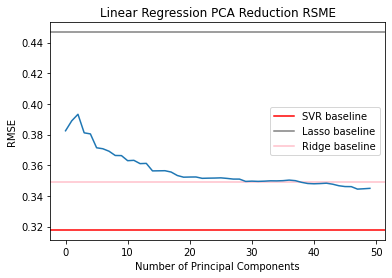

In [31]:
# add baselines
add_baselines(baselines)

plt.plot(linear_pca_rmses)

plt.xlabel('Number of Principal Components')
plt.ylabel('RMSE')
plt.title('Linear Regression PCA Reduction RSME');

### Ridge Regression with PCA reduction

In [32]:
ridge_pca = Ridge(random_state=rs)

# Fit 50 componentes with PCA and run with Ridge Regression
ridge_pca_rmses = component_reduction(X_train, y_train, ridge_pca, max_components=50, pca=True)

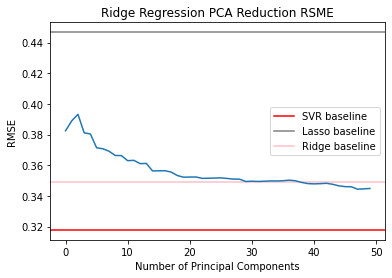

In [33]:
# add baselines
add_baselines(baselines)

plt.plot(ridge_pca_rmses)

plt.legend()
plt.xlabel('Number of Principal Components')
plt.ylabel('RMSE')
plt.title('Ridge Regression PCA Reduction RSME');

### SVR with PCA reduction

In [35]:
svr_pca = SVR(kernel='rbf')

# Fit through 50 components with PCA and run with SVA Regression
svr_pca_rmses = component_reduction(X_train, y_train, svr_pca, max_components=50, pca=True)

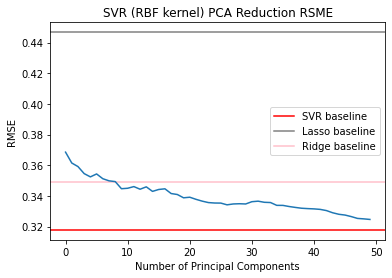

In [36]:
# add baselines
add_baselines(baselines)

plt.plot(svr_pca_rmses)

plt.legend()
plt.xlabel('Number of Principal Components')
plt.ylabel('RMSE')
plt.title('SVR (RBF kernel) PCA Reduction RSME');

## Partial Least Squares Regression

PCA didn't improve on the simple regression methods. But it isn't the only way to reduce the components of the data.

Partial Least Squares (PLS) Regression is similar to PCA in that it applies weights to all features and reduces the total number of components significantly. Unlike PCA, PLS is supervised, in that the weights are fitted on a combination of the X and y vectors. This method may be more useful in a regression model due to it's supervised nature.

### PLS test - Linear Regression with 10 Components

In [37]:
pls = PLSRegression(n_components=10)
X_train_pls = pls.fit(X_train, y_train)

In [38]:
X_train_pls = pls.transform(X_train)

In [39]:
# Check mean RMSE for 10 PLS components
linear_pls = LinearRegression()

r2_pls, rmse_pls = kfold_validate_score(X_train_pls, y_train, model=linear_pls)

print_scores(r2_pls, rmse_pls, "Linear Regression - PLS Component Reduction Cross-Validation")

Linear Regression - PLS Component Reduction Cross-Validation:

R-squared:     -0.5511
RMSE:          0.2979


With an RMSE of 0.298, PLS looks really promising. Let's try optimizing:

### Linear Regression with PLS

In [41]:
linear_pls = LinearRegression()

# Fit through 50 components and run with Linear Regression
linear_pls_rmses = component_reduction(X_train, y_train, linear_pls, max_components=50, pca=False)

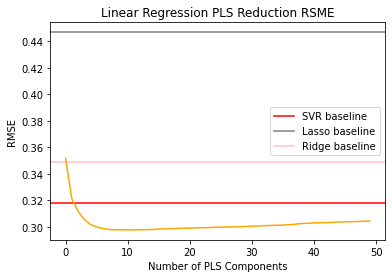

In [42]:
# add baselines
add_baselines(baselines)

plt.plot(linear_pls_rmses, color='orange')

plt.legend()
plt.xlabel('Number of PLS Components')
plt.ylabel('RMSE')
plt.title('Linear Regression PLS Reduction RSME');

### Ridge Regression with PLS

In [43]:
ridge_pls = Ridge(random_state=rs)

# Fit through 50 components and run with Linear Regression
ridge_pls_rmses = component_reduction(X_train, y_train, ridge_pls, max_components=50, pca=False)

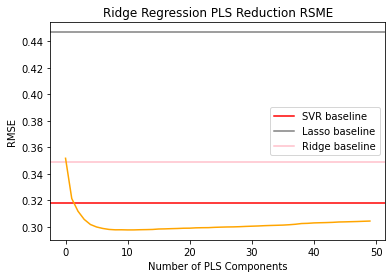

In [44]:
# add baselines
add_baselines(baselines)

plt.plot(ridge_pls_rmses, color='orange')

plt.legend()
plt.xlabel('Number of PLS Components')
plt.ylabel('RMSE')
plt.title('Ridge Regression PLS Reduction RSME');

### SVR with PLS

In [46]:
svr_rbf_pls = SVR(kernel='rbf')

# Fit through 50 components and run with Linear Regression
svr_pls_rmses = component_reduction(X_train, y_train, svr_rbf_pls, max_components=50, pca=False)

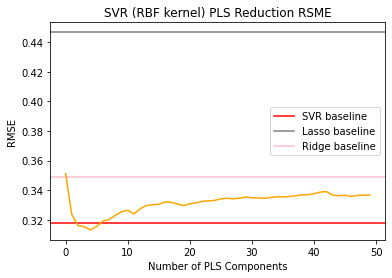

In [48]:
# add baselines
add_baselines(baselines)

plt.plot(svr_pls_rmses, color='orange')

plt.legend()
plt.xlabel('Number of PLS Components')
plt.ylabel('RMSE')
plt.title('SVR (RBF kernel) PLS Reduction RSME');

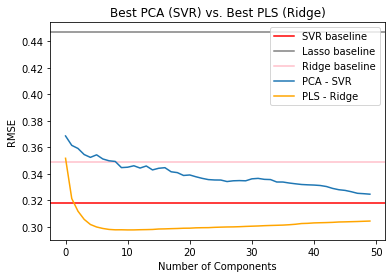

In [49]:
# add baselines
add_baselines(baselines)

plt.plot(svr_pca_rmses, label='PCA - SVR')
plt.plot(ridge_pls_rmses, label='PLS - Ridge', color='orange')

plt.legend()
plt.xlabel('Number of Components')
plt.ylabel('RMSE')
plt.title('Best PCA (SVR) vs. Best PLS (Ridge)');

### Ridge Regression - PLS "elbow"

It's difficult to determine how many PLS components are used to minimize the RMSE with Ridge Regression. Let's zoom in to get a better look.

In [50]:
ridge_pls = Ridge(random_state=rs)

# Fit through 30 components and run with Linear Regression
ridge_pls_rmses = component_reduction(X_train, y_train, ridge_pls, max_components=30, pca=False)

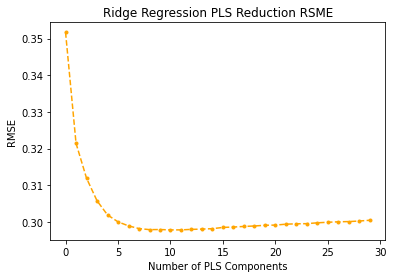

In [51]:
plt.plot(ridge_pls_rmses, color='orange', marker='.', linestyle='--')

plt.xlabel('Number of PLS Components')
plt.ylabel('RMSE')
plt.title('Ridge Regression PLS Reduction RSME');

At 7 components, it appers there is no further decrease in RMSE using Ridge Regression.

In [52]:
# Instatiate PLS with 7 components
pls = PLSRegression(n_components=7)

# Fit and transform data with the 7 component PLS
X_train_pls = pls.fit(X_train, y_train)
X_train_pls = pls.transform(X_train)

In [53]:
# Find mean RMSE through SVR Linear regression over 8 fold
ridge_pls = Ridge(random_state=rs)

ridge_pls_r2, ridge_pls_rmse = kfold_validate_score(X_train_pls, y_train, model=ridge_pls)

print_scores(ridge_pls_r2, ridge_pls_rmse, "Ridge Regression (PLS-7 Components) Cross-Validation")

Ridge Regression (PLS-7 Components) Cross-Validation:

R-squared:     -0.548
RMSE:          0.2989


## Grid Search Cross-Validation with Ridge Regression PLS

In [7]:
# Instatiate PLS with 7 components
pls = PLSRegression(n_components=7)

# Fit and transform data with the 7 component PLS
X_train_pls = pls.fit(X_train, y_train)
X_train_pls = pls.transform(X_train)

In [8]:
# Ignore warnings
import warnings
warnings.filterwarnings('ignore')

grid_model = Ridge(random_state=rs)

params = {
    'alpha': [0.1, 0.5, 1.0, 1.5, 2.0, 5.0, 10.0, 20.0, 30.0, 40.0, 50.0, 75.0, 100.0, 125.0, 150.0, 200.0],
    'solver': ['svd', 'cholesky', 'saga', 'sparse_cg', 'lsqr'],
}

grid_obj = GridSearchCV(grid_model, params, scoring='neg_root_mean_squared_error')

grid_fit = grid_obj.fit(X_train_pls, y_train)

best_model = grid_fit.best_estimator_

In [9]:
preds = best_model.predict(X_train_pls)

In [10]:
optimized_r2 = r2_score(y_train, preds)
optimized_rmse = mean_squared_error(y_train, preds, squared=False)

print_scores(optimized_r2, optimized_rmse, "Optimized Ridge Regression")

Optimized Ridge Regression:

R-squared:     0.5563
RMSE:          0.2978


In [11]:
grid_fit.best_estimator_

Ridge(alpha=10.0, random_state=37, solver='sparse_cg')

With an RMSE of 0.2978, compared to an RMSE of 0.2989 on the unoptimized model, there doesn't seem to be any significant improvement gained. However, the R-squared value rose from -0.548 to 0.5563. This shows that the optimized model fits the data better than the unoptimized model.

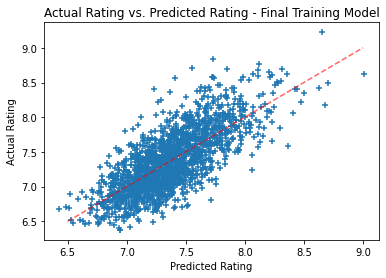

In [12]:
# Add accuracy line
plt.plot([6.5, 9], [6.5, 9], ls='--', c='r', alpha=0.6)
# Plot values
plt.scatter(preds, y_train, marker='+')

plt.title('Actual Rating vs. Predicted Rating - Final Training Model')
plt.xlabel('Predicted Rating')
plt.ylabel('Actual Rating');

In [13]:
pred_diff = y_train - preds

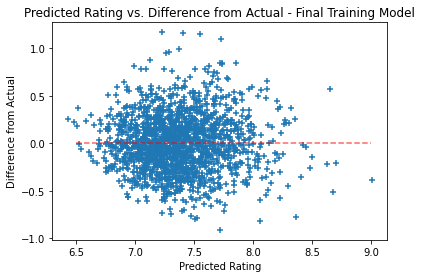

In [61]:
# Add zero line
plt.plot([6.5, 9], [0, 0], ls='--', c='r', alpha=0.6)
# Plot values
plt.scatter(preds, pred_diff, marker='+')

plt.title('Predicted Rating vs. Difference from Actual - Final Training Model')
plt.ylabel('Difference from Actual')
plt.xlabel('Predicted Rating');

## Production Model - First Deliverable

We will bring the above model -- `Ridge(alpha=10.0, random_state=37, solver='svd')` -- to production.

In [15]:
# Instatiate PLS with 7 components
pls = PLSRegression(n_components=7)

# Fit and transform data with the 7 component PLS - Training
X_train_pls = pls.fit(X_train, y_train)
X_train_pls = pls.transform(X_train)

# Transform test model
X_test_pls = pls.transform(X_test)

In [16]:
prod_model = best_model

prod_model = prod_model.fit(X_train_pls, y_train)

In [17]:
preds = prod_model.predict(X_test_pls)

prod_r2 = r2_score(y_test, preds)
prod_rmse = mean_squared_error(y_test, preds, squared=False)

In [18]:
print_scores(prod_r2, prod_rmse, "Production Model - Ridge Regression with PLS Reduction to 7 Components")

Production Model - Ridge Regression with PLS Reduction to 7 Components:

R-squared:     0.3931
RMSE:          0.343


The RMSE is 0.343, which is worse than the cross-validated results, but still respectable. This result may be higher due to some overfitting of the data in testing.

In [21]:
normalized_rmse = prod_rmse / score_range
normalized_rmse

0.12045235995906849

## Save model

In [22]:
with open("production_model.pkl", "wb") as f:
    pickle.dump(prod_model, f)

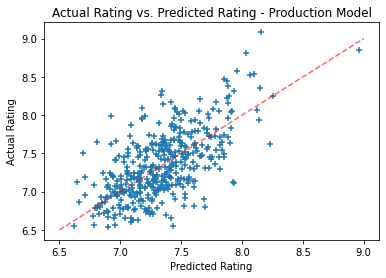

In [67]:
# Add accuracy line
plt.plot([6.5, 9], [6.5, 9], ls='--', c='r', alpha=0.6)
# Plot values
plt.scatter(preds, y_test, marker='+')

plt.title('Actual Rating vs. Predicted Rating - Production Model')
plt.xlabel('Predicted Rating')
plt.ylabel('Actual Rating');Unnamed: 0

In [68]:
pred_diff = y_test - preds

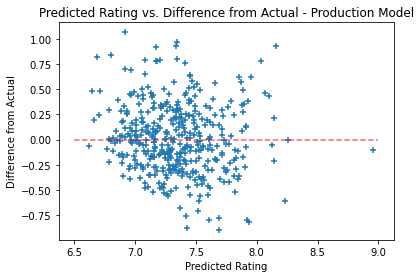

In [69]:
# Add zero line
plt.plot([6.5, 9], [0, 0], ls='--', c='r', alpha=0.6)
# Plot values
plt.scatter(preds, pred_diff, marker='+')

plt.title('Predicted Rating vs. Difference from Actual - Production Model')
plt.ylabel('Difference from Actual')
plt.xlabel('Predicted Rating');

## Interpreting PLS Components - Second Deliverable

Now that a model has been chosen, it is important to interpret the model. This will aid designers in designing games by showing what features have had a history of working well together.

In [70]:
# Create dataframe from X-weights used by PLS Regression
cols = [f'comp_{i}' for i in range(7)]

pls_weights = pd.DataFrame(pls.x_weights_, columns=cols, index=X_train.columns)

In [71]:
# Add abs value columns to make sorting easier
for col in pls_weights.columns:
    new_col_name = 'abs_' + col
    pls_weights[new_col_name] = np.abs(pls_weights[col])

### Get Ridge Regression Model Coefficients
   
Thes coefficients help in interpretation by seeing which components have a positive and which have a negative coefficient. The positive weights are desired on a component with a positve coefficient, and the negative weights are desired on a component with a negative coefficient.

In [72]:
prod_model.coef_

array([ 0.11725962,  0.09631509, -0.0492286 ,  0.03916476,  0.03555963,
        0.02784177,  0.02148316])

### Component 0 - coefficient 0.1173

In [73]:
pls_comp_list(pls_weights, 0, threshold=0.10)

weight                                            0.375092
Family Games (Subdomain)                         -0.226938
age                                               0.225743
Solo / Solitaire Game (Mechanism)                 0.180604
Scenario / Mission / Campaign Game (Mechanism)    0.180248
min_players                                      -0.169437
Wargame (Theme)                                   0.139682
Variable Player Powers (Mechanism)                0.138518
Miniatures (Theme)                                0.135865
Wargames (Subdomain)                              0.123270
Simulation (Mechanism)                            0.122214
Variable Set-up (Mechanism)                       0.121897
Tech Trees / Tech Tracks (Mechanism)              0.121158
Campaign / Battle Card Driven (Mechanism)         0.111713
Cooperative Game (Mechanism)                      0.109413
Party Game (Theme)                               -0.108310
Line of Sight (Mechanism)                         0.1042

### Analysis:

For the first component, there is a heavy weight toward game weight (essentially how complicated the game is). There is also a strong negative weight on Family Games, as well as a strong positive weight on Age.

The other weights above 0.125 indicate the games that are weighted highly on this component are games that can be played solo, games with scenarios/missions/campaigns, a smaller player count, a wargame, with variable player powers and miniatures.

This shows that Wargames and Family Games are opposite in regards to a lot of the features that are important to a game receiving a high score.

### Ideal game concept:

An ideal game that would score highly in this component would be a rules-heavy war game with scenarios or missions and the ablilty to play solo.

## Component 1

In [74]:
pls_comp_list(pls_weights, 1, threshold=0.10)

Party Games (Subdomain)                          0.222300
Dice Rolling (Mechanism)                        -0.197376
Area Movement (Mechanism)                       -0.179776
Party Game (Theme)                               0.165426
weight                                           0.149214
Acting (Mechanism)                               0.141935
Area Majority / Influence (Mechanism)           -0.140516
Deduction (Theme)                                0.140338
Pattern Building (Mechanism)                     0.137319
Thematic Games (Subdomain)                      -0.133380
End Game Bonuses (Mechanism)                     0.133244
Solo / Solitaire Game (Mechanism)                0.131943
Modular Board (Mechanism)                       -0.127973
Communication Limits (Mechanism)                 0.119912
Drawing (Mechanism)                              0.119639
Fighting (Theme)                                -0.117521
Pick-up and Deliver (Mechanism)                 -0.115815
max_players   

### Analysis:

The strongest weight for this component is a positive weight on the subdomain of Party Games. The strong negative weights scoring 2nd and 3rd indicate that Party Games do not implement Dice Rolling nor Area Movement to receive high rankings. There are moderate positive weights on Game Weight, Acting, Deduction, Pattern Building, End Game Bonuses, and (surprisingly for a Party Game) the ability to play Solo.

Moderate negative weights are on Area Majorit/Influence, the subdomain of Thematic Games, and Modular Boards.

This shows that Party Games with high scores use mechanics such as Acting, Deduction, and Pattern Building. The games that reward players at the end of the game with score bonuses score highly as well. The subdomain of Thematic Games seems to be opposite of Party Games in features that lead to high scores.

### Ideal game concept:

An ideal Party Game that would score highly in this component would be one that uses mechanics such as Acting or Deduction and would reward players at the end of the game with bonuses.

## Component 2

In [75]:
pls_comp_list(pls_weights, 2, threshold=0.10)

Income (Mechanism)                           0.209338
Strategy Games (Subdomain)                   0.190631
weight                                      -0.185323
Economic (Theme)                             0.177655
Miniatures (Theme)                          -0.164661
Victory Points as a Resource (Mechanism)     0.160039
Industry / Manufacturing (Theme)             0.154383
Worker Placement (Mechanism)                 0.151694
Fantasy (Theme)                             -0.140750
Follow (Mechanism)                           0.137029
Card Play Conflict Resolution (Mechanism)   -0.131847
Ownership (Mechanism)                        0.129737
Market (Mechanism)                           0.124954
Dice Rolling (Mechanism)                    -0.122027
Wargame (Theme)                             -0.119557
Network and Route Building (Mechanism)       0.114319
Sports (Theme)                              -0.113244
Wargames (Subdomain)                        -0.111644
Once-Per-Game Abilities (Mec

### Analysis:

This component prioritizes Strategy Games with income and economic elements. These games do beter with a lighter game weight and do not inclue miniatures. Victory points are also usable resources in the game. They have themes of industry and/or manufacturing, use a worker placement mechanic, and are not fantasy themed.

### Ideal game concept:

An ideal game that scores well on this component would be a Strategy Game that has a real-world theme in industry or manufacturing. It would need a monitary element. The money should be your score at the end of the game, so you have to balance saving money and spending it in hopes of making more later. The main mechanism of the game should be worker placement -- there are nodes on the game board that provide benefits to the player, but by one player occupying a node, another player could be locked out from using that node until a future round.

### Component 3

In [76]:
pls_comp_list(pls_weights, 3, threshold=0.10)

weight                                    0.365561
Role Playing (Mechanism)                 -0.194100
Party Game (Theme)                       -0.172286
Thematic Games (Subdomain)               -0.153729
Economic (Theme)                          0.144238
Set Collection (Mechanism)                0.143863
Strategy Games (Subdomain)                0.142247
Cooperative Game (Mechanism)             -0.139955
Auction/Bidding (Mechanism)               0.136229
Line of Sight (Mechanism)                -0.126053
Collectible Components (Theme)           -0.125341
Tile Placement (Mechanism)                0.123330
Transportation (Theme)                    0.122233
Communication Limits (Mechanism)         -0.119013
Book (Theme)                             -0.116640
Critical Hits and Failures (Mechanism)   -0.114582
Team-Based Game (Mechanism)              -0.108513
Semi-Cooperative Game (Mechanism)        -0.107491
Medieval (Theme)                          0.106045
Trading (Mechanism)            

### Analysis:

This component scores heavy, Strategy Games highly that have an Economic theme with Set Collection and Auction mechanisms. These games have opposite elements than Thematic Party Games with Role Playing and Cooperative Mechanisms.

The strongest weight by far in this component is game weight, so these elements are popular in very complex games.

### Ideal game concept:

An ideal game for this component would be a very complex Strategy Game with and Economic theme where the goal is to collect sets of items and you need to bid on those items. There would be a lot of player interaction through the bidding and the economy would be set by what the players find important and not set by the game rules.

## Component 4

In [77]:
pls_comp_list(pls_weights, 4, threshold=0.10)

weight                          0.309697
Deduction (Theme)               0.258597
Traitor Game (Mechanism)        0.193417
Storytelling (Mechanism)        0.184765
Party Games (Subdomain)         0.169374
Adventure (Theme)               0.165841
Murder/Mystery (Theme)          0.161756
Racing (Theme)                 -0.145884
Hidden Roles (Mechanism)        0.143775
Horror (Theme)                  0.132710
Strategy Games (Subdomain)     -0.126729
Race (Mechanism)               -0.125087
Bluffing (Theme)                0.123469
Sports (Theme)                 -0.117987
Cooperative Game (Mechanism)    0.114636
Predictive Bid (Mechanism)     -0.103943
Pattern Building (Mechanism)   -0.102489
Abstract Games (Subdomain)     -0.101746
Mythology (Theme)              -0.100404
Name: comp_4, dtype: float64

### Analysis:

For this component, a game is rewarded for being a complex game with a Deduction, Adventure, and/or Murder/Mystery theme with a player or players as a Traitor. Most likely this traitor role will be hidden from the non-traitor players. These games will tell a strong story and often have Horror elements as well.

### Ideal game concept:

An ideal game that would score well in this component would be a Horror game that told a strong story through the game play. There would be one or more players who would be traitors to the other players, and only they would know who the other traitors would be. The goal of the non-traitor players would be to deduce who the traitors were before the end of the game.

## Component 5

In [78]:
pls_comp_list(pls_weights, 5, threshold=0.10)

weight                                           0.267936
Role Playing (Mechanism)                        -0.213677
Family Games (Subdomain)                         0.200271
Thematic Games (Subdomain)                      -0.172659
Strategy Games (Subdomain)                      -0.158660
Auction/Bidding (Mechanism)                     -0.148571
Ratio / Combat Results Table (Mechanism)         0.147348
age                                             -0.143596
Hidden Roles (Mechanism)                        -0.136535
Negotiation (Theme)                             -0.136179
Movement Points (Mechanism)                      0.128379
Wargame (Theme)                                  0.126086
Mythology (Theme)                               -0.121962
Traitor Game (Mechanism)                        -0.119535
Variable Player Powers (Mechanism)              -0.119015
Negotiation (Mechanism)                         -0.116477
Simulation (Mechanism)                           0.114168
Action Points 

### Analysis:

This component is a little more difficult to interpret that the previous components. This component seems to prioritize somewhat complex Family Games for a younger audience. These games would be Wargames with combat and limited movement. These games would have opposite elements from Thematic or Strategy Games and involve little to no role playing or negotiation.

## Component 6

In [79]:
pls_comp_list(pls_weights, 6, threshold=0.10)

weight                                      0.316971
Wargames (Subdomain)                       -0.208799
World War I (Theme)                        -0.203630
World War II (Theme)                       -0.190776
Race (Mechanism)                            0.164634
Simulation (Mechanism)                     -0.154210
Hand Management (Mechanism)                 0.134507
Card Game (Theme)                           0.131025
Fighting (Theme)                            0.128090
avg_time                                   -0.127201
Area Majority / Influence (Mechanism)       0.126782
Follow (Mechanism)                          0.125456
Kill Steal (Mechanism)                      0.122033
min_players                                 0.120795
Wargame (Theme)                            -0.117159
Bribery (Mechanism)                         0.110878
Trains (Theme)                             -0.107412
Humor (Theme)                               0.104802
Ratio / Combat Results Table (Mechanism)   -0.

### Analysis:

The final component used to predict the score are more complex games that use cards as the interface for the player to influence the game. There could be a combination of different themes, such as racing, fighting, or area control. These games are likely not a war game and not set during either of the World Wars.

There is also a negative weight on average time, so these games are likely quicker than other games to play and finish the game.

### Ideal game concept:

An ideal game in this component would be a racing game that used cards to control the vehicle. There should be ways to attack and influence the other players, so there would be a high amount of player interaction. This game should not take a very long time to play.